In [114]:
import numpy as np
import pandas as pd
import glob
import time
from scipy import signal


In [115]:
def butter_filter(order, low_pass, high_pass, fs,sig):
    nyq = 0.5 * fs
    lp = low_pass / nyq
    hp = high_pass / nyq
    sos = signal.butter(order, [lp, hp], btype='band', output = 'sos')
    return signal.sosfilt(sos, sig)

In [182]:
'''
extract_d(files)
Ingest Data by looping through files

Epoch 1.3 seconds after feedbackevent == 1 using epoch_d function

Append values to list of arrays called temp


Input: 
    files: array of string of file names (Data_S*_Sess*.csv)
Output: 
    temp: final array of appended values
'''
def extract_d(files, e_s = None, baseline = True, bandpass = True):
    start = time.time()
    
    training_subjects = 16 #num of training subjects
    num_of_fb = 340 #num of feedbacks / subject
    freq = 200 #sampling rate
    epoch_time = 1.3 #proposed epoching time in seconds
    epoch = int(freq * epoch_time) #epoch in indices 
    epoch_s = int(freq * e_s)
    num_of_cols = int(59) 
    eeg_cols = int(56)
    b_s = int(-0.4*freq) #index where baseline starts relative to feedback (-400ms)
    b_e = int(-0.3*freq) #index where baseline ends relative to feedback (-300ms)
    order = 5 #butterworth order
    low_pass = 1 #low frequency pass for butterworth filter
    high_pass = 40 #high frequency pass for butterworth filter
    
    channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1',
       'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
       'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2',
       'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4',
       'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
       'PO7', 'POz', 'P08', 'O1', 'O2']
    
    temp = np.empty((1,epoch-epoch_s,num_of_cols), float)
    for i, f in enumerate(files):
        print(i,f, temp.shape)
        df = pd.read_csv(f) #read each file
        index_fb = df[df['FeedBackEvent'] == 1].index.values
        df_array = np.array(df) 
        
        #uncomment below for butterworth filter
        if bandpass == True:
            eeg = df_array[:,1:57] #only eeg values to apply butterworth filter
            for i, channel in enumerate(channels):
                raw_eeg = df[channel].values
                eeg_filtered = butter_filter(order, low_pass, high_pass, freq, raw_eeg) #butterworth filter applied
                eeg[:,i] = eeg_filtered
            df = np.array(df)
            df[:,1:57] = eeg #replacing old eeg values with new ones
        else:
            df = np.array(df)
        
        for j, indx in enumerate(index_fb): #epoching 260 indexes (1.3 seconds) after each stimulus
            if e_s != None:
                epoch_array = df[indx+epoch_s:(indx+int(epoch)),:]
                epoch_array = epoch_array.reshape((1,int(epoch)-int(epoch_s),int(epoch_array.shape[1])))
            else:
                epoch_array = df[indx:(indx+int(epoch)),:]
                epoch_array = epoch_array.reshape((1,int(epoch),int(epoch_array.shape[1])))

            #uncomment below for baseline correction
            if baseline == True:
                baseline_array = df[indx+b_s:indx+b_e, 1:57] #baseline correction of 100ms (20 indexes), 400ms to 300ms before fb
                baseline_array = baseline_array.reshape((1,20,int(baseline_array.shape[1])))
                baseline_mean = np.mean(baseline_array, axis = 1)
                epoch_array[:,:,1:57] = epoch_array[:,:,1:57] - baseline_mean #noise subtracted from epoched data
            
            if i == 0:
                temp = np.vstack((temp,epoch_array)) #stacking the first epoch
            else:
                temp = np.vstack((temp,epoch_array))
                
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return temp

In [175]:
train_files = glob.glob('Data/train/Data*.csv')
test_files = glob.glob('Data/test/Data*.csv')
train_files[0:6]

['Data/train\\Data_S02_Sess01.csv',
 'Data/train\\Data_S02_Sess02.csv',
 'Data/train\\Data_S02_Sess03.csv',
 'Data/train\\Data_S02_Sess04.csv',
 'Data/train\\Data_S02_Sess05.csv',
 'Data/train\\Data_S06_Sess01.csv']

In [176]:
# Notice: Because of the way the data was epoched, for some reason, the training and test data start with an array of zeros
# Make you keep this in mind.
train = extract_d(train_files[:1], -0.4)

0 Data/train\Data_S02_Sess01.csv (1, 340, 59)
Elapsed Time: 3 seconds


In [34]:
import matplotlib.pyplot as plt

In [87]:
np.arange(0,1.7,0.005).shape

(340,)

In [42]:
np.arange(0,1.3,0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25])

0 Data/train\Data_S02_Sess01.csv (1, 340, 59)
Elapsed Time: 1 seconds


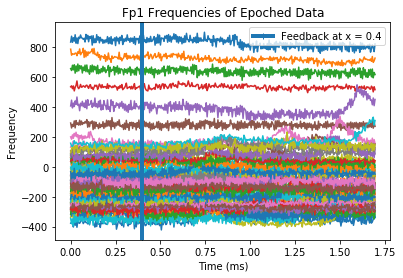

In [183]:
#Not baseline corrected no filter
x = np.arange(0,1.7,0.005)
train = extract_d(train_files[:1], -0.4, False, False)
train = train[1:,:,:]
first_electrode = train[:,:340,1]

for i in np.arange(60):
    y = first_electrode[i,:]
    plt.plot(x, y)
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency')
    plt.title('Fp1 Frequencies of Epoched Data')
plt.axvline(x=0.4, marker = '|', linewidth = 4, label = 'Feedback at x = 0.4')
plt.legend()
plt.show()

0 Data/train\Data_S02_Sess01.csv (1, 340, 59)
Elapsed Time: 1 seconds


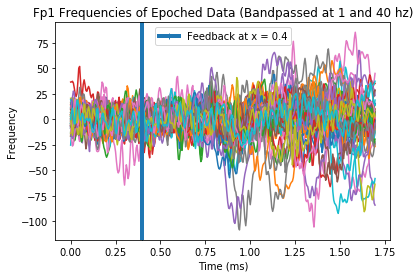

In [184]:
#Bandpassed, not baseline corrected
x = np.arange(0,1.7,0.005)
train = extract_d(train_files[:1], -0.4, baseline = False, bandpass = True)
train = train[1:,:,:]
first_electrode = train[:,:340,1]
for i in np.arange(60):
    y = first_electrode[i,:]
    plt.plot(x, y)
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency')
    plt.title('Fp1 Frequencies of Epoched Data (Bandpassed at 1 and 40 hz)')
plt.axvline(x=0.4, marker = '|', linewidth = 4, label = 'Feedback at x = 0.4')
plt.legend()
plt.show()

0 Data/train\Data_S02_Sess01.csv (1, 340, 59)
Elapsed Time: 1 seconds


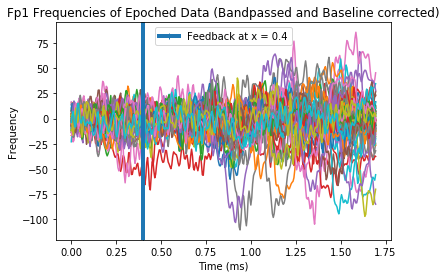

In [185]:
#Bandpassed, and baseline corrected
x = np.arange(0,1.7,0.005)
train = extract_d(train_files[:1], -0.4, baseline = True, bandpass = True)
train = train[1:,:,:]
first_electrode = train[:,:340,1]
for i in np.arange(60):
    y = first_electrode[i,:]
    plt.plot(x, y)
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency')
    plt.title('Fp1 Frequencies of Epoched Data (Bandpassed and Baseline corrected)')
plt.axvline(x=0.4, marker = '|', linewidth = 4, label = 'Feedback at x = 0.4')
plt.legend()
plt.show()

In [6]:
# Notice: Because of the way the data was epoched, for some reason, the training and test data start with an array of zeros
# Make you keep this in mind.
test = extract_d(test_files[:5])

0 Data/test\Data_S01_Sess01.csv (1, 260, 59)
1 Data/test\Data_S01_Sess02.csv (61, 260, 59)
2 Data/test\Data_S01_Sess03.csv (121, 260, 59)
3 Data/test\Data_S01_Sess04.csv (181, 260, 59)
4 Data/test\Data_S01_Sess05.csv (241, 260, 59)
Elapsed Time: 18 seconds
